In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS, TracePredictive
from pyro.distributions import constraints

# Single Level Model
In our simplest model, we will just model each post.

# Data

First, we load the Reddit datasets

In [2]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [3]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [4]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [5]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [6]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

In [7]:
# select relevant indep vars
# p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors, num initial comments
p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
t_data = data[:,1].reshape(-1,1)

# add bias terms
biases = np.ones_like(t_data)
p_data = np.concatenate((biases, p_data), axis=1)
t_data = np.concatenate((biases, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1)

split into train/test

In [8]:
np.random.seed(0)

train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to torch tensors

In [9]:
p_data_train = torch.Tensor(p_data_train)
p_data_test = torch.Tensor(p_data_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

Post-Level Regression

y_p = phi_0 * bias + phi_1 * first_hour_comments + epsilon

In [10]:
def model_no_subsample(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_prior = dist.Normal(torch.zeros((num_p_indeps, 1)),
                            10. * torch.ones((num_p_indeps, 1)))  # (num_p_indeps, 1)
    phi = pyro.sample("phi", phi_prior)  # (num_p_indeps, 1)
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 1000.))

    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", size=num_posts) as p:

        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts, num_p_indeps)
        
        # calculate the mean
        mu = torch.matmul(indeps, phi)  # (num_posts, num_p_indeps) (num_p_indeps, 1)
        
        # sample
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=y)  # (num_posts, 1)

In [11]:
def model(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_loc = torch.zeros((num_p_indeps, 1))  # (num_p_indeps, 1)
    phi_scale = 10. * torch.ones((num_p_indeps, 1))  # (num_p_indeps, 1)
    sigma_loc = 0.
    sigma_scale = 100.
    
    phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))  # (num_p_indeps, 1)
    sigma = pyro.sample("sigma", dist.Uniform(sigma_loc, sigma_scale))  # float

    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", size=num_posts, subsample_size=100) as p:
        
        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts_sub, num_p_indeps)
        
        # calculate the mean
        mu = torch.matmul(indeps, phi)  # (num_posts_sub, num_p_indeps) (num_p_indeps, 1)
        
        # sample
        if y is not None:
            return pyro.sample("obs", dist.Normal(mu, sigma), obs=y[p])  # (num_posts_sub, 1)
        else:
            return pyro.sample("obs", dist.Normal(mu, sigma), obs=y)  # (num_posts_sub, 1)

In [12]:
def guide(p_data, y):
    num_posts, num_p_indeps = p_data.shape
    
    # define a prior for our regression variables
    phi_loc = pyro.param("phi_loc", torch.zeros((num_p_indeps, 1)))  # (num_p_indeps, 1)
    phi_scale = pyro.param("phi_scale", torch.ones((num_p_indeps, 1)),  # (num_p_indeps, 1)
                              constraint=constraints.positive)
    
    sigma_loc = pyro.param('sigma_loc', torch.Tensor([1.]), 
                           constraint=constraints.positive)  # (1)
    sigma_scale = pyro.param('sigma_scale', torch.Tensor([0.05]),
                            constraint=constraints.positive)
    
    phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))  # (num_p_indeps, 1)
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, sigma_scale))  # (1)
    return phi, sigma

---

# Inference

## SVI

In [13]:
SUBSET_DATA = True

svi = SVI(model,
          guide,
          optim.Adam({"lr": .1}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()
num_iters = 10000
losses = np.zeros((num_iters,))
for i in range(num_iters):
    if SUBSET_DATA:
        elbo = svi.step(p_data_train[:100], y_train[:100])
    else:
        elbo = svi.step(p_data_train, y_train)
    losses[i] = elbo

<ipython-input-12-6f5c75929035>:9: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  sigma_loc = pyro.param('sigma_loc', torch.Tensor([1.]),
<ipython-input-12-6f5c75929035>:11: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  sigma_scale = pyro.param('sigma_scale', torch.Tensor([0.05]),


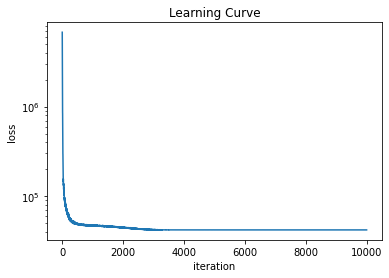

In [14]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

Get samples from posterior (and calculate fitted params)

In [15]:
num_samples = 1000
svi_phi_posterior_samples = np.empty((2, num_samples))
svi_sigma_posterior_samples = np.empty((num_samples, 1))

for i in range(num_samples):
    phi, sigma = guide(p_data_train[:100], y_train[:100])
    svi_phi_posterior_samples[:,i] = phi.detach().numpy().flatten()
    svi_sigma_posterior_samples[i,:] = sigma.detach().numpy().flatten()
    
svi_phi_posterior = svi_phi_posterior_samples.mean(axis=1)
svi_sigma_posterior = svi_sigma_posterior_samples.mean(axis=0)

print(svi_phi_posterior)
print(svi_sigma_posterior)

[ 5.0216226  12.63495737]
[15.68146779]


Get fitted params (last estimate from training?)

In [16]:
svi_phi_loc = pyro.param('phi_loc').detach().numpy().flatten()
svi_phi_scale = pyro.param('phi_scale').detach().numpy().flatten()

svi_sigma_loc = pyro.param('sigma_loc').detach().numpy()[0]
svi_sigma_scale = pyro.param('sigma_scale').detach().numpy()[0]

In [17]:
print("phi_loc\t\t", svi_phi_loc[0], svi_phi_loc[1])
print("phi_scale\t", svi_phi_scale[0], svi_phi_scale[1])

print("sigma_loc\t", svi_sigma_loc)
print("sigma_scale\t", svi_sigma_scale)

phi_loc		 5.0216227 12.632486
phi_scale	 0.15476507 0.0717945
sigma_loc	 15.68233
sigma_scale	 0.0745875


Get posterior predictive samples

In [18]:
num_samples = 1000
svi_predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in svi_predictive(p_data_test, None).items()
               if k != 'obs'}

In [19]:
svi_samples['phi'].mean(axis=1)

array([[ 5.0231843, 12.632117 ]], dtype=float32)

In [20]:
svi_samples['sigma'].mean(axis=1)

array([[15.679427]], dtype=float32)

## MCMC (NUTS)

In [21]:
kernel = NUTS(model_no_subsample, target_accept_prob=0.8, adapt_step_size=True)

num_iters = 1000
warmup_steps = 1000
mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
mcmc.run(p_data_train[:100], y_train[:100])

Sample: 100%|██████████| 2000/2000 [00:18, 108.84it/s, step size=7.55e-01, acc. prob=0.903]


In [22]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  phi[0,0]      4.98      0.16      4.98      4.72      5.24    693.22      1.00
  phi[1,0]     12.63      0.06     12.63     12.53     12.72    722.17      1.00
     sigma     15.70      0.11     15.70     15.52     15.87   1026.04      1.00

Number of divergences: 0


Get samples from posterior (and manually calculate fitted params)

In [23]:
mcmc_posterior_samples = mcmc.get_samples()

In [24]:
mcmc_phi_loc = mcmc_posterior_samples["phi"].detach().numpy().mean(axis=0).flatten()
mcmc_phi_scale = mcmc_posterior_samples["phi"].detach().numpy().std(axis=0).flatten()

mcmc_sigma_loc = mcmc_posterior_samples["sigma"].detach().numpy().mean(axis=0)
mcmc_sigma_scale = mcmc_posterior_samples["sigma"].detach().numpy().std(axis=0)

In [25]:
print("phi_loc\t\t", mcmc_phi_loc[0], mcmc_phi_loc[1])
print("phi_scale\t", mcmc_phi_scale[0], mcmc_phi_scale[1])

print("sigma_loc\t", mcmc_sigma_loc)
print("sigma_scale\t", mcmc_sigma_scale)

phi_loc		 4.9841723 12.632239
phi_scale	 0.16015914 0.060878865
sigma_loc	 15.701699
sigma_scale	 0.10670868


Get posterior predictive samples

In [26]:
mcmc_predictive = Predictive(model=model_no_subsample, 
                             posterior_samples=mcmc_posterior_samples)

note: mcmc_predictive is slow when applied to large datasets (capping to 1k test obs here)

In [27]:
mcmc_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in mcmc_predictive(p_data_test[:1000], None).items()}

In [28]:
mcmc_samples

{'obs': array([[[ -0.3870244 ,  26.036404  ,  15.447357  , ...,   7.276146  ,
          -25.191206  ,  -8.267453  ],
         [  9.188456  , -12.055855  ,   4.648344  , ...,   3.174644  ,
           16.04879   ,  -0.07617569],
         [  8.042955  ,   6.297173  ,  -4.642354  , ...,  -2.05576   ,
           17.770203  , -13.347265  ],
         ...,
         [  6.961954  ,  -0.51118803,   9.547241  , ...,  17.589245  ,
           35.72495   ,  18.683573  ],
         [-10.91132   ,  19.114185  ,   4.6986895 , ...,  -2.7779622 ,
           26.33244   ,   1.9831645 ],
         [-11.929011  ,  -0.3879676 ,   1.1292198 , ..., -16.155731  ,
          -12.491767  ,  51.66281   ]]], dtype=float32)}

returns only obs? svi returns obs and params

---

# Evaluation

Check the fit

In [29]:
xmin = float(p_data_train[:100,1].min())
xmax = float(p_data_train[:100,1].max())

xs = np.linspace(xmin, xmax, num=100)

In [30]:
indep = 1

indep_dict = {
    1: "comments in first hour",
}

# svi
y_pred_svi = svi_phi_loc[0]
y_pred_svi += svi_phi_loc[1] * p_data_train[:100,indep].detach().numpy()

y_reg_svi = svi_phi_loc[0]
y_reg_svi += svi_phi_loc[1] * xs

# mcmc
y_pred_mcmc = mcmc_phi_loc[0]
y_pred_mcmc += mcmc_phi_loc[1] * p_data_train[:100,indep].detach().numpy()

y_reg_mcmc = mcmc_phi_loc[0]
y_reg_mcmc += mcmc_phi_loc[1] * xs

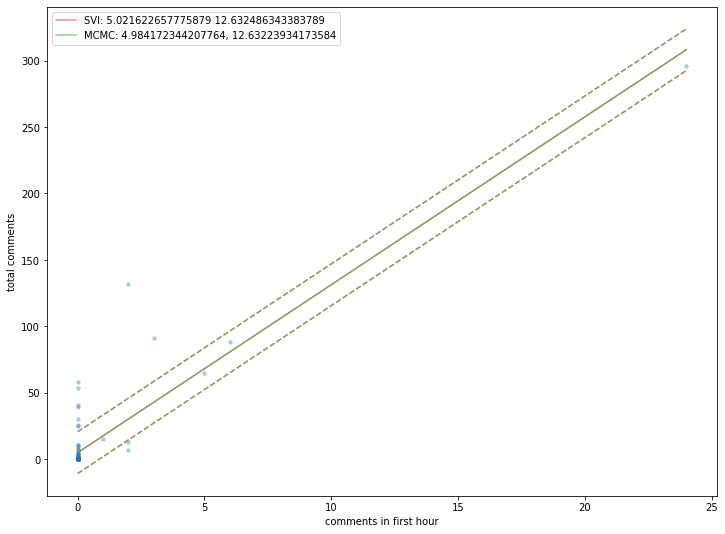

In [31]:
plt.figure(figsize=(12,9))
plt.scatter(np.array(p_data_train[:100,indep]), np.array(y_train[:100]), alpha=0.3, s=12, c='tab:blue')

plt.plot(xs, np.array(y_reg_svi), alpha=0.5, c='tab:red', label=f'SVI: {svi_phi_loc[0]} {svi_phi_loc[1]}') # SVI
plt.plot(xs, np.array(y_reg_svi)+svi_sigma_loc, '--', alpha=0.5, c='tab:red')
plt.plot(xs, np.array(y_reg_svi)-svi_sigma_loc, '--', alpha=0.5, c='tab:red')

plt.plot(xs, np.array(y_reg_mcmc), alpha=0.5, c='tab:green', label=f'MCMC: {mcmc_phi_loc[0]}, {mcmc_phi_loc[1]}') # MCMC
plt.plot(xs, np.array(y_reg_mcmc)+mcmc_sigma_loc, '--', alpha=0.5, c='tab:green')
plt.plot(xs, np.array(y_reg_mcmc)-mcmc_sigma_loc, '--', alpha=0.5, c='tab:green')

plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')
plt.legend()
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 5 comments in total
- For every comment in the first hour, we expect an additional 10 comments in total

Check residuals (diff between predicted comments and actual comments)

In [32]:
residual_svi = np.abs(y_train[:100].detach().numpy().reshape(-1,) - y_pred_svi)
residual_mcmc = np.abs(y_train[:100].detach().numpy().reshape(-1,) - y_pred_mcmc)

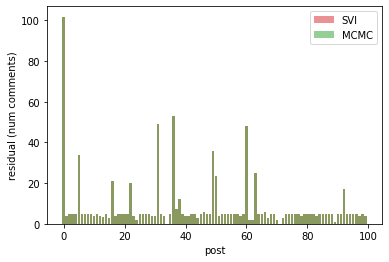

In [33]:
plt.bar(range(len(residual_svi)), residual_svi, alpha=0.5, color='tab:red', label='SVI')
plt.bar(range(len(residual_mcmc)), residual_mcmc, alpha=0.5, color='tab:green', label='MCMC')
plt.ylabel('residual (num comments)')
plt.xlabel('post')
plt.legend()
plt.show()

## Arviz plots

Estimated posterior distribution

/usr/local/lib/python3.8/site-packages/arviz/data/io_pyro.py:152: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


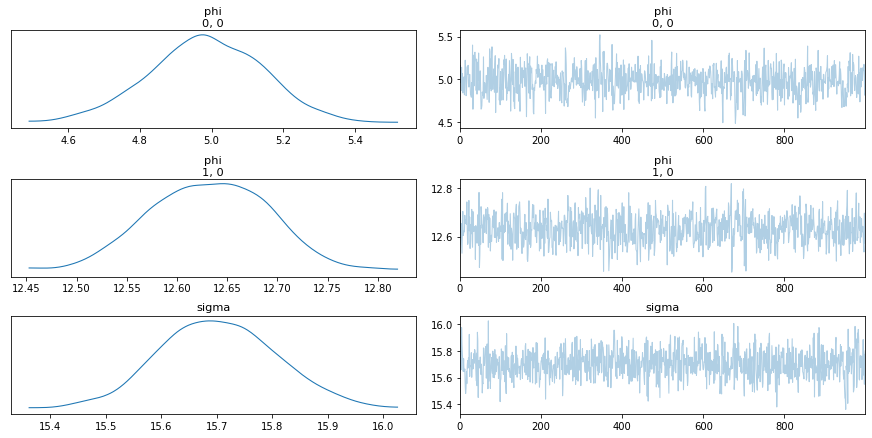

In [34]:
mcmc_data = az.from_pyro(mcmc)
az.plot_trace(mcmc_data, compact=False);

Posterior predictive distribution

In [37]:
#mcmc_data = az.convert_to_inference_data(mcmc_samples)
#az.plot_trace(mcmc_data, compact=False);

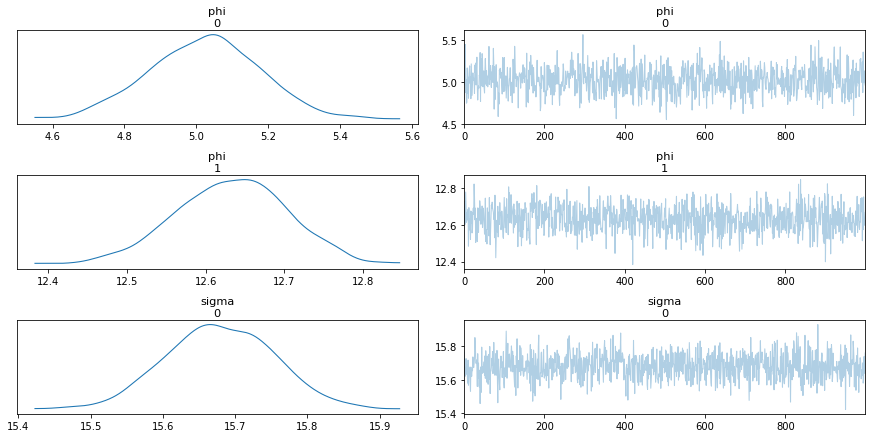

In [38]:
svi_data = az.convert_to_inference_data(svi_samples)
az.plot_trace(svi_data, compact=False);

other evaluation plots (only using svi here)

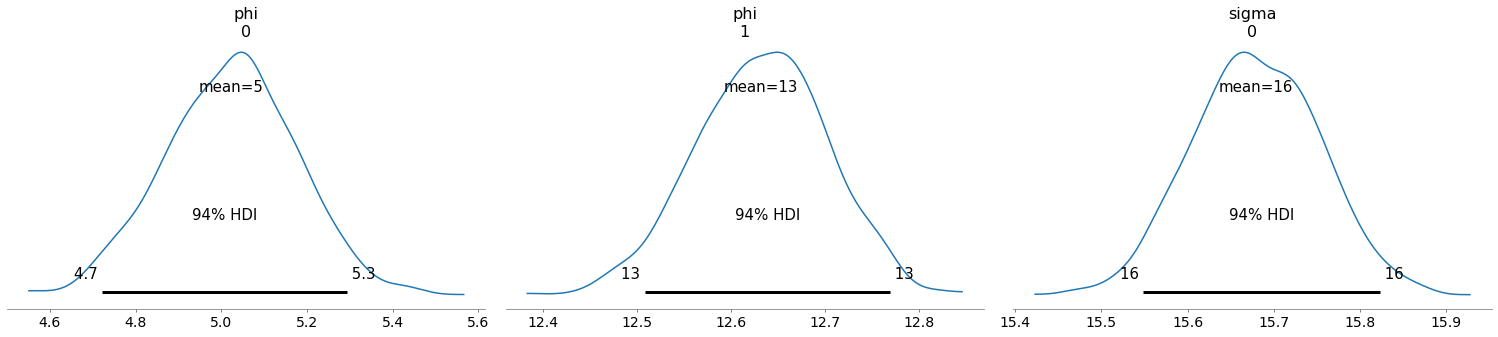

In [39]:
az.plot_posterior(svi_data)
plt.show()

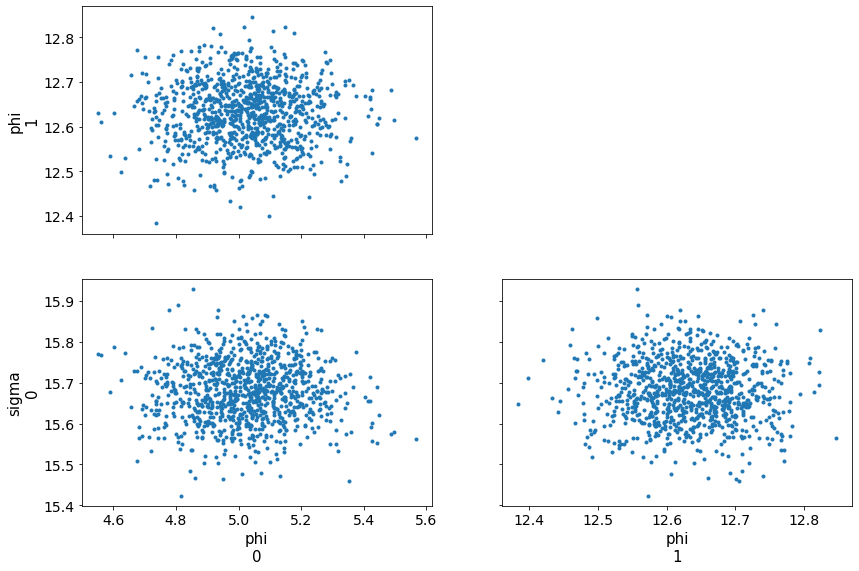

In [40]:
az.plot_pair(svi_data)
plt.show()

---